<a href="https://colab.research.google.com/github/TemiloluwaAdeniyi/Bootcamp2019/blob/master/Spotify_Recommendation_App.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing Neccesary Libraries**

In [44]:
#Import Libraries
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from sklearn.ensemble import RandomForestClassifier
!pip install boruta
from boruta import BorutaPy
from sklearn import metrics
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from pandas import read_csv
from numpy import set_printoptions
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [ ]:
## I ran this initial code in Google Colab, so I use the data import commands for Google Colab here and imported a data set from
## Kaggle Spotify repository with songs from 1921 - 2020. The data can also be pulled directly from Spotify with the API. I'm going to also
## put those commands here for future reference.
### Set up query
#sp = spotipy.Spotify(
#            client_credentials_manager=SpotifyClientCredentials(
#            client_id=client_id,
#            client_secret=client_secret))

# **Loading Data**

In [2]:
#Load CSV File of Spotify Data into Google Colab Environment
from google.colab import files
x = files.upload()

Saving data_w_genres.csv to data_w_genres.csv


In [61]:
#Store Data into Dataframe
df = pd.read_csv('data_w_genres.csv')

# **Prepping/Cleaning Data**

In [62]:
df.head()

,artists,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key,mode,count,genres
0,"""Cats"" 1981 Original London Cast",0.575083,0.442750,247260.000000,0.386336,0.022717,0.287708,-14.205417,0.180675,115.983500,0.334433,38.000000,5,1,12,['show tunes']
1,"""Cats"" 1983 Broadway Cast",0.862538,0.441731,287280.000000,0.406808,0.081158,0.315215,-10.690000,0.176212,103.044154,0.268865,33.076923,5,1,26,[]
2,"""Fiddler On The Roof” Motion Picture Chorus",0.856571,0.348286,328920.000000,0.286571,0.024593,0.325786,-15.230714,0.118514,77.375857,0.354857,34.285714,0,1,7,[]
3,"""Fiddler On The Roof” Motion Picture Orchestra",0.884926,0.425074,262890.962963,0.245770,0.073587,0.275481,-15.639370,0.123200,88.667630,0.372030,34.444444,0,1,27,[]
4,"""Joseph And The Amazing Technicolor Dreamcoat""...",0.605444,0.437333,232428.111111,0.429333,0.037534,0.216111,-11.447222,0.086000,120.329667,0.458667,42.555556,11,1,9,[]


In [63]:
#List column names
#'genres' is the target feature
list(df.columns.values)

['artists',
 'acousticness',
 'danceability',
 'duration_ms',
 'energy',
 'instrumentalness',
 'liveness',
 'loudness',
 'speechiness',
 'tempo',
 'valence',
 'popularity',
 'key',
 'mode',
 'count',
 'genres']

In [64]:
#Check Size of Data (rows x columns) before cleaning
df.shape

(27621, 16)

In [65]:
#Drop Duplicate Song Entries
df = df.drop_duplicates()

In [66]:
#Drop Song Entries if Genre is Missing
df = df[df.astype(str)['genres'] != '[]']

In [67]:
df

,artists,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key,mode,count,genres
0,"""Cats"" 1981 Original London Cast",0.575083,0.442750,247260.000000,0.386336,0.022717,0.287708,-14.205417,0.180675,115.983500,0.334433,38.000000,5,1,12,['show tunes']
9,"""Weird Al"" Yankovic",0.176934,0.664788,218165.257576,0.685136,0.000046,0.162139,-9.877909,0.082392,132.495091,0.754409,33.681818,9,1,132,"['antiviral pop', 'comedy rock', 'comic', 'par..."
11,$NOT,0.547000,0.750125,152929.500000,0.519750,0.043137,0.213975,-8.878500,0.276725,114.229125,0.319500,64.625000,6,1,8,"['east coast hip hop', 'gangster rap', 'hardco..."
13,$uicideBoy$,0.128123,0.765246,147549.442623,0.641705,0.038454,0.201195,-6.626918,0.155917,119.804361,0.296096,61.647541,1,1,122,"['dark trap', 'new orleans rap', 'underground ..."
15,'In The Heights' Original Broadway Company,0.636588,0.541000,301908.294118,0.402282,0.000008,0.193824,-9.405882,0.150006,114.952529,0.407765,46.588235,7,1,17,"['broadway', 'show tunes']"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27611,陳秀男,0.473500,0.553500,263286.500000,0.609000,0.000392,0.229000,-9.361000,0.035300,98.847500,0.535500,44.000000,7,1,2,['taiwan campus folk']
27612,陳蘭麗,0.502000,0.609000,152883.000000,0.833000,0.000000,0.134000,-6.261000,0.215000,154.596000,0.718000,34.000000,0,1,2,['taiwan campus folk']
27616,鳳飛飛,0.884000,0.358000,259387.000000,0.208000,0.000002,0.150000,-9.524000,0.033900,131.261000,0.278000,35.000000,10,1,2,"['c-pop', 'classic mandopop', 'vintage chinese..."
27617,黃品源,0.541000,0.578000,293840.000000,0.334000,0.000006,0.067500,-11.974000,0.026700,135.934000,0.243000,47.000000,9,0,2,"['c-pop', 'classic cantopop', 'classic mandopop']"


In [68]:
df.shape
#9,530 songs were removed that didn't have genres entered

(18091, 16)

In [69]:
#Drop Song Entries with Any Missing Values
df = df.dropna(how='any')

In [70]:
df.shape
#no further songs were removed from dataframe with additional missing values

(18091, 16)

In [71]:
df.head()
#dataframe post clean-up

,artists,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key,mode,count,genres
0,"""Cats"" 1981 Original London Cast",0.575083,0.442750,247260.000000,0.386336,0.022717,0.287708,-14.205417,0.180675,115.983500,0.334433,38.000000,5,1,12,['show tunes']
9,"""Weird Al"" Yankovic",0.176934,0.664788,218165.257576,0.685136,0.000046,0.162139,-9.877909,0.082392,132.495091,0.754409,33.681818,9,1,132,"['antiviral pop', 'comedy rock', 'comic', 'par..."
11,$NOT,0.547000,0.750125,152929.500000,0.519750,0.043137,0.213975,-8.878500,0.276725,114.229125,0.319500,64.625000,6,1,8,"['east coast hip hop', 'gangster rap', 'hardco..."
13,$uicideBoy$,0.128123,0.765246,147549.442623,0.641705,0.038454,0.201195,-6.626918,0.155917,119.804361,0.296096,61.647541,1,1,122,"['dark trap', 'new orleans rap', 'underground ..."
15,'In The Heights' Original Broadway Company,0.636588,0.541000,301908.294118,0.402282,0.000008,0.193824,-9.405882,0.150006,114.952529,0.407765,46.588235,7,1,17,"['broadway', 'show tunes']"


In [72]:
#Remove Secondary Genres to Simplify Analysis
df.genres = df.genres.str.split(',').str[0].str.strip()
df.genres.head()

0            ['show tunes']
9          ['antiviral pop'
11    ['east coast hip hop'
13             ['dark trap'
15              ['broadway'
Name: genres, dtype: object

In [73]:
df

,artists,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key,mode,count,genres
0,"""Cats"" 1981 Original London Cast",0.575083,0.442750,247260.000000,0.386336,0.022717,0.287708,-14.205417,0.180675,115.983500,0.334433,38.000000,5,1,12,['show tunes']
9,"""Weird Al"" Yankovic",0.176934,0.664788,218165.257576,0.685136,0.000046,0.162139,-9.877909,0.082392,132.495091,0.754409,33.681818,9,1,132,['antiviral pop'
11,$NOT,0.547000,0.750125,152929.500000,0.519750,0.043137,0.213975,-8.878500,0.276725,114.229125,0.319500,64.625000,6,1,8,['east coast hip hop'
13,$uicideBoy$,0.128123,0.765246,147549.442623,0.641705,0.038454,0.201195,-6.626918,0.155917,119.804361,0.296096,61.647541,1,1,122,['dark trap'
15,'In The Heights' Original Broadway Company,0.636588,0.541000,301908.294118,0.402282,0.000008,0.193824,-9.405882,0.150006,114.952529,0.407765,46.588235,7,1,17,['broadway'
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27611,陳秀男,0.473500,0.553500,263286.500000,0.609000,0.000392,0.229000,-9.361000,0.035300,98.847500,0.535500,44.000000,7,1,2,['taiwan campus folk']
27612,陳蘭麗,0.502000,0.609000,152883.000000,0.833000,0.000000,0.134000,-6.261000,0.215000,154.596000,0.718000,34.000000,0,1,2,['taiwan campus folk']
27616,鳳飛飛,0.884000,0.358000,259387.000000,0.208000,0.000002,0.150000,-9.524000,0.033900,131.261000,0.278000,35.000000,10,1,2,['c-pop'
27617,黃品源,0.541000,0.578000,293840.000000,0.334000,0.000006,0.067500,-11.974000,0.026700,135.934000,0.243000,47.000000,9,0,2,['c-pop'


# **Feature Selection**

In [74]:
#Define Independent Variable Columns
X = df.iloc[:,0:15]

In [75]:
#Define the Target Column AKA Output Column
y = df.iloc[:,-1]

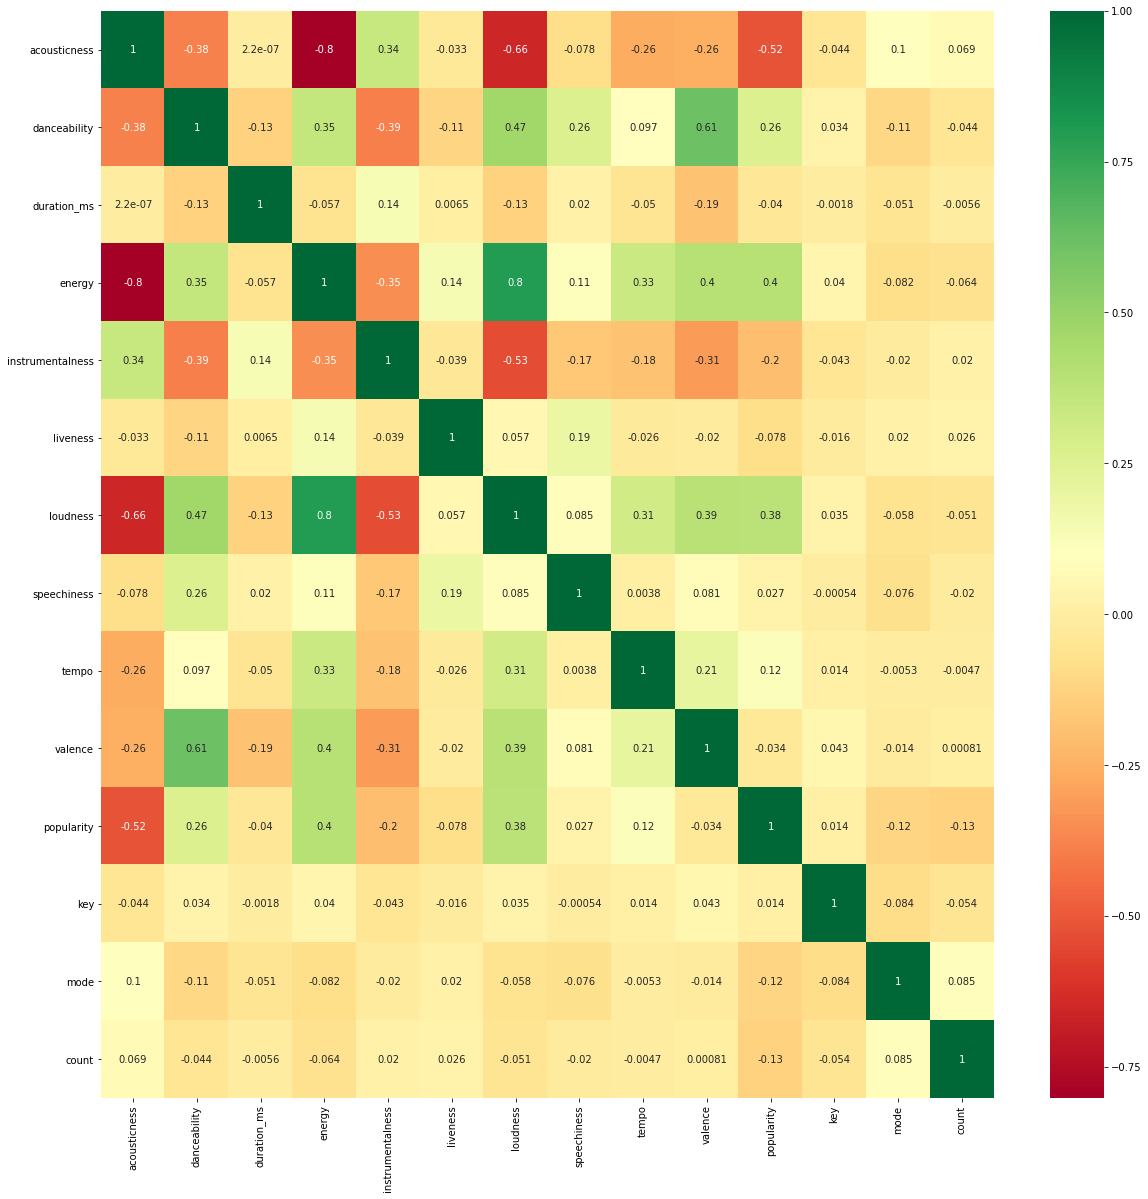

In [76]:
#Gather Correlations of Each Feature in the Data Set and Configure Correlation Map
corrmat = df.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
g=sns.heatmap(df[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [77]:
corrmat

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key,mode,count
acousticness,1.000000e+00,-0.381977,2.246655e-07,-0.801522,0.338983,-0.032676,-0.658091,-0.078005,-0.260689,-0.257185,-0.518653,-0.043680,0.103018,0.069097
danceability,-3.819770e-01,1.000000,-1.319432e-01,0.354776,-0.386553,-0.112652,0.467806,0.264804,0.097313,0.613760,0.262123,0.034282,-0.106659,-0.044316
duration_ms,2.246655e-07,-0.131943,1.000000e+00,-0.057310,0.135900,0.006505,-0.129043,0.020465,-0.050042,-0.186602,-0.040383,-0.001826,-0.051362,-0.005630
energy,-8.015216e-01,0.354776,-5.730973e-02,1.000000,-0.349227,0.144959,0.799025,0.106811,0.325123,0.400460,0.399176,0.039755,-0.082497,-0.063521
instrumentalness,3.389829e-01,-0.386553,1.359003e-01,-0.349227,1.000000,-0.039330,-0.534474,-0.165316,-0.183188,-0.313275,-0.201045,-0.043456,-0.020101,0.020298
liveness,-3.267643e-02,-0.112652,6.504646e-03,0.144959,-0.039330,1.000000,0.056812,0.194738,-0.026412,-0.020080,-0.078072,-0.016257,0.020266,0.025985
loudness,-6.580910e-01,0.467806,-1.290427e-01,0.799025,-0.534474,0.056812,1.000000,0.085389,0.308009,0.389433,0.381738,0.034852,-0.058216,-0.050928
speechiness,-7.800457e-02,0.264804,2.046515e-02,0.106811,-0.165316,0.194738,0.085389,1.000000,0.003753,0.081273,0.027053,-0.000536,-0.075865,-0.019665
tempo,-2.606885e-01,0.097313,-5.004194e-02,0.325123,-0.183188,-0.026412,0.308009,0.003753,1.000000,0.206544,0.119223,0.014331,-0.005314,-0.004681
valence,-2.571849e-01,0.613760,-1.866023e-01,0.400460,-0.313275,-0.020080,0.389433,0.081273,0.206544,1.000000,-0.034029,0.043431,-0.014159,0.000812


In [ ]:
#Correlation with output variable
cor_target = abs(corrmat["genres"])

In [ ]:
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.5]
relevant_features

In [46]:
#Convert Float Values to Dummy Placeholder Values for Feature Selection
df_dummy = pd.get_dummies(df, drop_first= False)

In [27]:
#df_artist = df.artists
#df_backup = df

In [38]:
#df = df_backup

In [35]:
#Append Artists for Dummy Conversion
idx = 0
df_artists = df.artists
df = df_dummy.insert(loc=idx, column='artists', value= df_artists)

In [ ]:
#apply SelectKBest class to extract top 3 best features
bestfeatures = SelectKBest(score_func=chi2, k=3)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

In [ ]:
#Artists, instrumentalness and energy top three, significant features for clusters in data
#Also, will be important in predicting genre
#After cleaning the data further, after the initial version of the code, the top three predictors have changed. 

# **Predicting w/ K-Nearest Neighbors**

In [ ]:
#Import train_test_split function
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

In [79]:
# Split dataset into training set and test set
#80% training and 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [82]:
#Create KNN Classifier
knn = KNeighborsClassifier(n_neighbors=7)

In [92]:
X_train_2 = pd.get_dummies(X_train, drop_first= False)
y_train_2 = pd.get_dummies(y_train, drop_first= False)
X_test_2 = pd.get_dummies(X_test, drop_first= False)
y_test = pd.get_dummies(y_test, drop_first= False)

In [93]:
#Train the model using the training sets
knn.fit(X_train_2, y_train_2)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=7, p=2,
                     weights='uniform')

In [94]:
X_test_2 = pd.get_dummies(X_test, drop_first= False)

In [ ]:
#Predict the response for test dataset
y_pred = knn.predict(X_test_2)